In [3]:
# ==========================================================
#  IMPORTING ALL THE NECESSARY LIBs
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor


In [ ]:
# ==========================================================
# LOADING THE INPUT TEST AND TRAIN DATA
# ==========================================================

train_path = r"C:\Users\91995\Downloads\train_v9rqX0R.csv"
test_path  = r"C:\Users\91995\Downloads\test_AbJTz2l.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df["control"] = "Train"
test_df["control"]  = "Test"

full_df = pd.concat([train_df, test_df], ignore_index=True)


In [ ]:
# ==========================================================
#  Exploratory Data Analysis
# ==========================================================

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Dairy'),
  Text(1, 0, 'Soft Drinks'),
  Text(2, 0, 'Meat'),
  Text(3, 0, 'Fruits and Vegetables'),
  Text(4, 0, 'Household'),
  Text(5, 0, 'Baking Goods'),
  Text(6, 0, 'Snack Foods'),
  Text(7, 0, 'Frozen Foods'),
  Text(8, 0, 'Breakfast'),
  Text(9, 0, 'Health and Hygiene'),
  Text(10, 0, 'Hard Drinks'),
  Text(11, 0, 'Canned'),
  Text(12, 0, 'Breads'),
  Text(13, 0, 'Starchy Foods'),
  Text(14, 0, 'Others'),
  Text(15, 0, 'Seafood')])

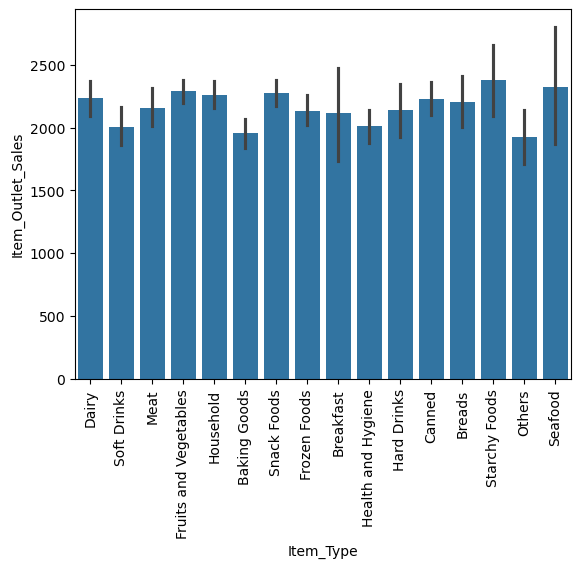

In [ ]:


# ========  Sales by Product Properties --------------

sns.barplot(x="Item_Type", y="Item_Outlet_Sales", data=train_df)
plt.xticks(rotation=90)


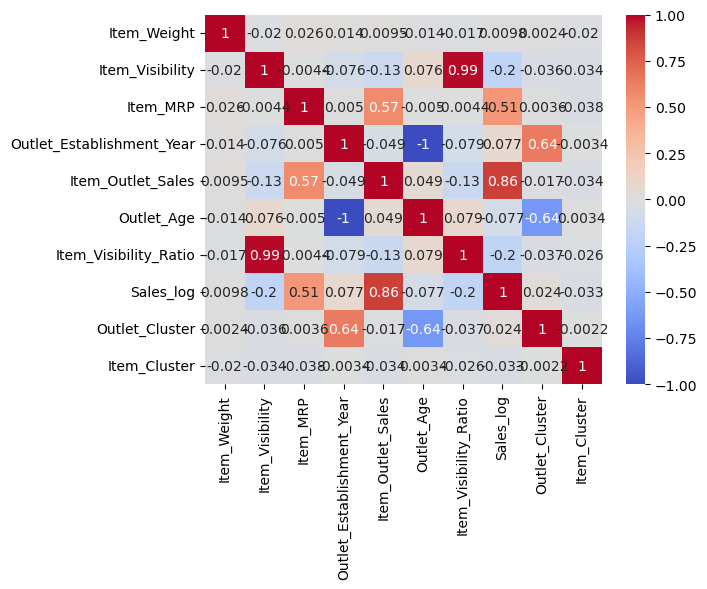

In [69]:
# Heatmap of Correlation (Numerical Features)
numeric_df = train_df.select_dtypes(include=["number"])

sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.show()


<Axes: xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

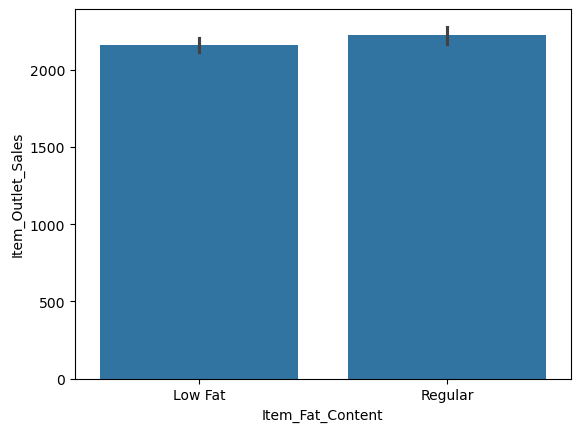

In [67]:
sns.barplot(x="Item_Fat_Content", y="Item_Outlet_Sales", data=train_df)

<Axes: xlabel='Item_Type', ylabel='Outlet_Type'>

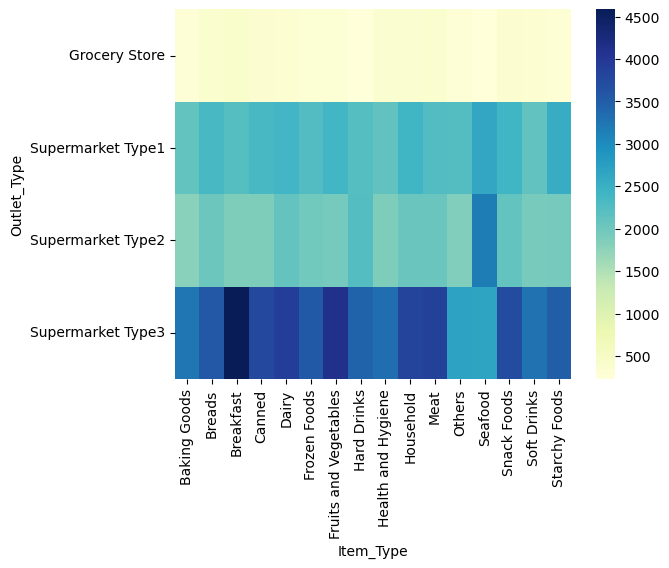

In [71]:
# Boxplot of Sales by Outlet_Type
sns.boxplot(x="Outlet_Type", y="Item_Outlet_Sales", data=train_df)


# --------  Pivot Table Heatma/
pivot = train_df.pivot_table(
    values="Item_Outlet_Sales",
    index="Outlet_Type",
    columns="Item_Type",
    aggfunc="mean"
)

sns.heatmap(pivot, cmap="YlGnBu")

In [56]:
# ==========================================================
# DATA CLEANING
# ==========================================================

def normalize_fat_content(x):
    x = str(x).lower()
    if "low" in x or x in ["lf", "lowfat"]:
        return "Low Fat"
    return "Regular"

full_df["Item_Fat_Content"] = full_df["Item_Fat_Content"].apply(normalize_fat_content)

# Replace zero visibility
full_df["Item_Visibility"] = full_df["Item_Visibility"].replace(0, np.nan)

# Fill missing
full_df["Item_Weight"] = full_df.groupby("Item_Type")["Item_Weight"]\
                                 .transform(lambda x: x.fillna(x.median()))

full_df["Item_Visibility"] = full_df.groupby("Item_Type")["Item_Visibility"]\
                                     .transform(lambda x: x.fillna(x.median()))

full_df["Outlet_Size"] = full_df.groupby("Outlet_Type")["Outlet_Size"]\
                                 .transform(lambda x: x.fillna(x.mode()[0]))


In [57]:
# ==========================================================
# FEATURE ENGINEERING
# ==========================================================

full_df["Outlet_Age"] = 2013 - full_df["Outlet_Establishment_Year"]

# MRP Band
full_df["Item_MRP_Band"] = pd.qcut(
    full_df["Item_MRP"],
    4,
    labels=["Low", "Medium", "High", "Very High"]
)

# Visibility Ratio
full_df["Item_Visibility_Ratio"] = (
    full_df["Item_Visibility"] /
    full_df.groupby("Item_Type")["Item_Visibility"].transform("mean")
)


food_items = [
    "Dairy", "Meat", "Fruits and Vegetables", "Baking Goods",
    "Snack Foods", "Frozen Foods", "Breakfast", "Canned",
    "Breads", "Starchy Foods", "Seafood"
]

drink_items = ["Soft Drinks", "Hard Drinks"]

other_items = ["Household", "Health and Hygiene", "Others"]

def map_segregation(x):
    if x in food_items:
        return "Food"
    elif x in drink_items:
        return "Drinks"
    else:
        return "Others"

full_df["Item_segregation"] = full_df["Item_Type"].apply(map_segregation)


display(full_df.head(2))

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,control,Outlet_Age,Item_MRP_Band,Item_Visibility_Ratio,Item_segregation
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,14,Very High,0.213619,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,4,Low,0.279707,Drinks


In [58]:
# ==========================================================
# OUTLIER TREATMENT (IQR CAPPING)
# ==========================================================

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

cap_outliers(full_df[full_df["control"]=="Train"], "Item_Outlet_Sales")


# display(full_df.head(2))

In [59]:
# ==========================================================
#  LOG TRANSFORMATION (BASED ON SKEW)
# ==========================================================

train_mask = full_df["control"] == "Train"

# Log target (right-skewed)
full_df.loc[train_mask, "Sales_log"] = np.log1p(
    full_df.loc[train_mask, "Item_Outlet_Sales"]
)

# Log visibility (high skew)
full_df["Item_Visibility"] = np.log1p(full_df["Item_Visibility"])


In [60]:
# ==========================================================
#  CLUSTERING (USED AS FEATURES)
# ==========================================================

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


# ----------    Outlet Clustering   ----------------
outlet_df = full_df[
    ["Outlet_Identifier", "Outlet_Age",
     "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]
].drop_duplicates()

le_cols = ["Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

for col in le_cols:
    outlet_df[col] = LabelEncoder().fit_transform(outlet_df[col])

scaler = StandardScaler()
scaled = scaler.fit_transform(outlet_df.drop("Outlet_Identifier", axis=1))

kmeans_outlet = KMeans(n_clusters=4, random_state=42, n_init=10)
outlet_df["Outlet_Cluster"] = kmeans_outlet.fit_predict(scaled)

full_df = full_df.merge(
    outlet_df[["Outlet_Identifier", "Outlet_Cluster"]],
    on="Outlet_Identifier",
    how="left"
)


# ----------    Item Clustering  ----------------

item_df = full_df[
    ["Item_Identifier", "Item_MRP_Band","Item_segregation",
     "Item_Fat_Content", "Item_Type", "control"]
].drop_duplicates()

for col in ["Item_MRP_Band", "Item_Fat_Content", "Item_Type","Item_segregation"]:
    item_df[col] = LabelEncoder().fit_transform(item_df[col])

scaled_item = StandardScaler().fit_transform(
    item_df.drop(['Item_Identifier','control'], axis=1)
)

kmeans_item = KMeans(n_clusters=4, random_state=42, n_init=10)

item_df["Item_Cluster"] = kmeans_item.fit_predict(scaled_item)

item_df = item_df[['Item_Identifier','Item_MRP_Band','Item_Fat_Content','Item_Type','Item_segregation', 'Item_Cluster','control']] \
    .drop_duplicates(subset=['Item_Identifier','control'])

full_df = full_df.merge(
    item_df[["Item_Identifier", "control", "Item_Cluster"]],
    on=['Item_Identifier','control'],
    how="left"
)

full_df = full_df.drop_duplicates().reset_index(drop=True)

print((full_df).shape[0])
print((full_df[full_df['control'] == 'Test']).shape[0])
display(full_df.head(2))

14204
5681


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,control,Outlet_Age,Item_MRP_Band,Item_Visibility_Ratio,Item_segregation,Sales_log,Outlet_Cluster,Item_Cluster
0,FDA15,9.30,Low Fat,0.015920,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train,14,Very High,0.213619,Food,8.225808,0,3
1,DRC01,5.92,Regular,0.019095,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train,4,Low,0.279707,Drinks,6.096776,3,1


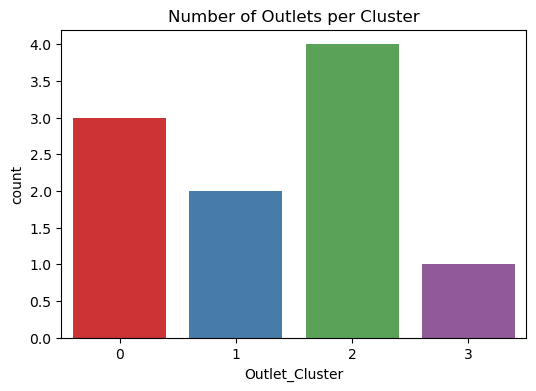

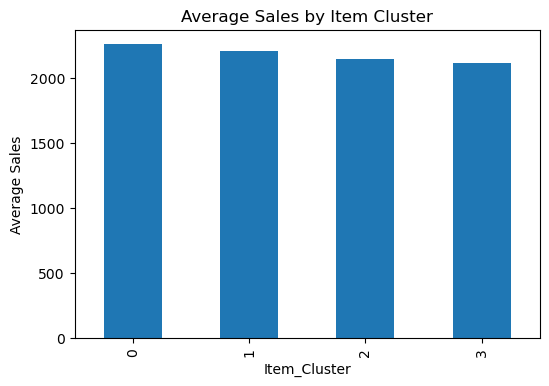

In [ ]:
# ------------------    Visualize Outlet Clusters   --------------------

# Outlet Cluster Distribution
plt.figure(figsize=(6,4))
sns.countplot(
    x="Outlet_Cluster",
    data=outlet_df,
    palette="Set1"
)

plt.title("Number of Outlets per Cluster")
plt.show()


# Item Cluster vs Avg Sales
item_cluster_sales = full_df.groupby("Item_Cluster")["Item_Outlet_Sales"].mean()

item_cluster_sales.plot(kind="bar", figsize=(6,4))
plt.title("Average Sales by Item Cluster")
plt.ylabel("Average Sales")
plt.show()





In [61]:
# ==========================================================
#  PREPARE MODEL DATA
# ==========================================================
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy")


train_df = full_df[full_df["control"]=="Train"].copy()
test_df  = full_df[full_df["control"]=="Test"].copy()



X = train_df.drop(
    ["Item_Outlet_Sales", "Sales_log", "control"],
    axis=1
)

y = train_df["Sales_log"]

X_test = test_df.drop(
    ["Item_Outlet_Sales", "control"],
    axis=1,
    errors="ignore"
)

# One-hot encoding
combined = pd.concat([X, X_test])
combined = pd.get_dummies(combined, drop_first=True)

X = combined.iloc[:len(X)]
X_test = combined.iloc[len(X):]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)



# --------------    RANDOM FOREST   ----------------------------------

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_preds = np.expm1(rf.predict(X_val))
rf_rmse = np.sqrt(mean_squared_error(np.expm1(y_val), rf_preds))

print("Random Forest RMSE:", rf_rmse)


# --------------    PROPER XGBOOST   ----------------------------------

xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_preds = np.expm1(xgb.predict(X_val))
xgb_rmse = np.sqrt(mean_squared_error(np.expm1(y_val), xgb_preds))

print("XGBoost RMSE:", xgb_rmse)


# --------------    TUNED XGBOOST   ----------------------------------

param_grid = {
    "max_depth": [5,6,7],
    "learning_rate": [0.01, 0.03],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "n_estimators": [1000, 1500]
}

grid = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_

tuned_preds = np.expm1(best_xgb.predict(X_val))
tuned_rmse = np.sqrt(
    mean_squared_error(np.expm1(y_val), tuned_preds)
)

print("Tuned XGBoost RMSE:", tuned_rmse)





Random Forest RMSE: 1040.9843318920139
XGBoost RMSE: 1069.8030208236228
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Tuned XGBoost RMSE: 1050.6521776507525


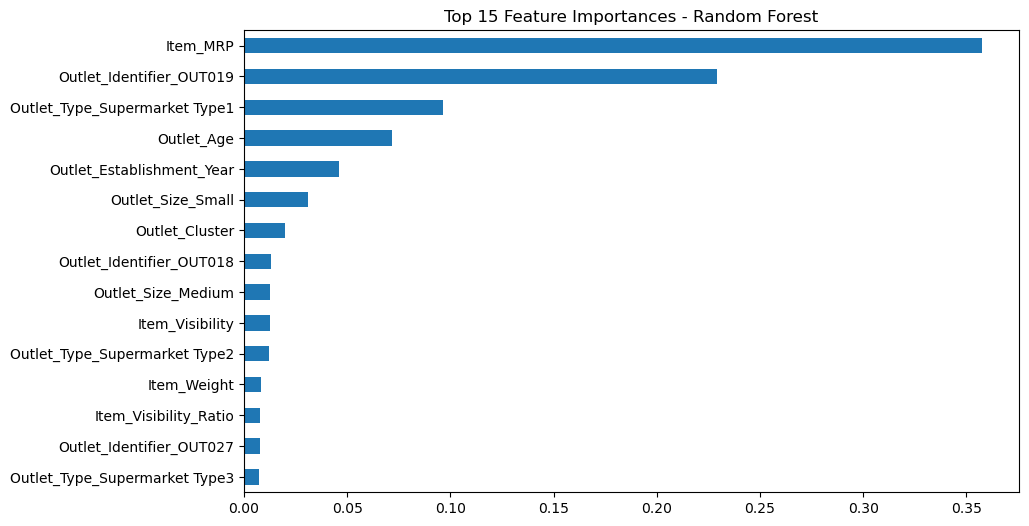

In [ ]:
# --------------------      Feature Importance (Tree-Based Models) After training RandomForest      ------------------

import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()


In [64]:
# FINAL TEST PREDICTION

final_preds = np.expm1(rf.predict(X_test))

submission = test_df[["Item_Identifier", "Outlet_Identifier"]].copy()
submission["Item_Outlet_Sales"] = final_preds

submission.to_csv(r"C:\Users\91995\Downloads\Final_BigMart_Submission.csv", index=False)


In [62]:
y_val_actual = np.expm1(y_val)

val_results = X_val.copy()
val_results["Item_Type"] = train_df.loc[X_val.index, "Item_Type"]
val_results["Actual"] = y_val_actual
val_results["RF_Pred"] = rf_preds
val_results["XGB_Pred"] = tuned_preds


from sklearn.metrics import mean_squared_error

model_choice = {}

for item in val_results["Item_Type"].unique():

    subset = val_results[val_results["Item_Type"] == item]

    rmse_rf = np.sqrt(mean_squared_error(
        subset["Actual"], subset["RF_Pred"]
    ))

    rmse_xgb = np.sqrt(mean_squared_error(
        subset["Actual"], subset["XGB_Pred"]
    ))

    if rmse_rf < rmse_xgb:
        model_choice[item] = "RF"
    else:
        model_choice[item] = "XGB"

print(model_choice)


{'Frozen Foods': 'RF', 'Health and Hygiene': 'XGB', 'Canned': 'XGB', 'Soft Drinks': 'RF', 'Meat': 'RF', 'Snack Foods': 'RF', 'Baking Goods': 'RF', 'Household': 'RF', 'Dairy': 'RF', 'Fruits and Vegetables': 'XGB', 'Seafood': 'XGB', 'Breakfast': 'XGB', 'Breads': 'RF', 'Starchy Foods': 'RF', 'Others': 'XGB', 'Hard Drinks': 'RF'}


In [63]:
# ----------------  Retraining Both Models on FULL DATA ------------------------------

rf.fit(X, y)
best_xgb.fit(X, y)

# ---   full test predictions

test_pred_rf = np.expm1(rf.predict(X_test))
test_pred_xgb = np.expm1(best_xgb.predict(X_test))


# -----------   Create Hybrid Predictions   ------------------------------

test_results = test_df.copy()
test_results["RF_Pred"] = test_pred_rf
test_results["XGB_Pred"] = test_pred_xgb

final_preds = []

for idx, row in test_results.iterrows():

    item_type = row["Item_Type"]

    if model_choice.get(item_type) == "RF":
        final_preds.append(row["RF_Pred"])
    else:
        final_preds.append(row["XGB_Pred"])

final_preds = np.array(final_preds)


# -----  FINAL TEST Submission  --------------------------

submission = test_df[["Item_Identifier", "Outlet_Identifier"]].copy()
submission["Item_Outlet_Sales"] = final_preds

submission.to_csv(
    r"C:\Users\91995\Downloads\Hybrid_ItemType_Ensemble.csv",
    index=False
)

print("Hybrid ensemble submission created.")


Hybrid ensemble submission created.


In [31]:
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

gkf = GroupKFold(n_splits=5)
groups = train_df["Outlet_Identifier"]

rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(train_df, train_df["Item_Outlet_Sales"], groups)):

    fold_train = train_df.iloc[train_idx].copy()
    fold_val   = train_df.iloc[val_idx].copy()

    # --------------------------------------------------
    # LOG TARGET
    # --------------------------------------------------
    fold_train["log_target"] = np.log1p(fold_train["Item_Outlet_Sales"])
    fold_val["log_target"]   = np.log1p(fold_val["Item_Outlet_Sales"])

    # --------------------------------------------------
    # TARGET ENCODING (NO LEAKAGE)
    # --------------------------------------------------
    global_mean = fold_train["log_target"].mean()

    for col in ["Outlet_Type", "Item_Type"]:

        means = fold_train.groupby(col)["log_target"].mean()

        fold_train[col+"_te"] = fold_train[col].map(means)
        fold_val[col+"_te"]   = fold_val[col].map(means)

        fold_val[col+"_te"] = fold_val[col+"_te"].fillna(global_mean)

    # --------------------------------------------------
    # DROP TARGET + IDS
    # --------------------------------------------------
    drop_cols = [
        "Item_Outlet_Sales",
        "log_target",
        "Item_Identifier",
        "Outlet_Identifier"
    ]

    X_train = fold_train.drop(columns=drop_cols)
    y_train = fold_train["log_target"]

    X_val = fold_val.drop(columns=drop_cols)
    y_val = fold_val["log_target"]

    # --------------------------------------------------
    # ONE HOT (COMBINED TO MATCH COLUMNS)
    # --------------------------------------------------
    X_combined = pd.concat([X_train, X_val], axis=0)
    X_combined = pd.get_dummies(X_combined, drop_first=True)

    X_train = X_combined.iloc[:len(X_train)]
    X_val   = X_combined.iloc[len(X_train):]

    # --------------------------------------------------
    # RANDOM FOREST (STRONG SETTINGS)
    # --------------------------------------------------
    rfk = RandomForestRegressor(
        n_estimators=1200,
        max_depth=14,
        min_samples_split=8,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    rfk.fit(X_train, y_train)

    preds = np.expm1(rfk.predict(X_val))
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), preds))

    rmse_scores.append(rmse)

    print(f"Fold {fold+1} RMSE: {rmse:.2f}")

print("\nGroup CV RMSE:", np.mean(rmse_scores))


Fold 1 RMSE: 1659.25
Fold 2 RMSE: 602.12
Fold 3 RMSE: 514.67
Fold 4 RMSE: 785.91
Fold 5 RMSE: 594.76

Group CV RMSE: 831.3411425260749


In [32]:

# --------------------------------------------------
# FULL TRAIN PREPARATION
# --------------------------------------------------

train_full = train_df.copy()
test_full  = test_df.copy()

train_full["log_target"] = np.log1p(train_full["Item_Outlet_Sales"])

global_mean = train_full["log_target"].mean()

for col in ["Outlet_Type", "Item_Type"]:
    means = train_full.groupby(col)["log_target"].mean()

    train_full[col+"_te"] = train_full[col].map(means)
    test_full[col+"_te"]  = test_full[col].map(means)

    test_full[col+"_te"] = test_full[col+"_te"].fillna(global_mean)

# --------------------------------------------------
# DROP TARGET + IDS
# --------------------------------------------------

drop_cols_train = [
    "Item_Outlet_Sales",
    "log_target",
    "Item_Identifier",
    "Outlet_Identifier"
]

drop_cols_test = [
    "Item_Identifier",
    "Outlet_Identifier"
]

X = train_full.drop(columns=drop_cols_train)
y = train_full["log_target"]

X_test = test_full.drop(columns=drop_cols_test)

# --------------------------------------------------
# ONE HOT ENCODING (CRITICAL STEP)
# --------------------------------------------------

combined = pd.concat([X, X_test], axis=0)
combined = pd.get_dummies(combined, drop_first=True)

X = combined.iloc[:len(X)]
X_test = combined.iloc[len(X):]

# --------------------------------------------------
# FINAL RANDOM FOREST TRAINING
# --------------------------------------------------

rf_final = RandomForestRegressor(
    n_estimators=1200,
    max_depth=14,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X, y)

# --------------------------------------------------
# FINAL PREDICTIONS
# --------------------------------------------------

final_preds = np.expm1(rf_final.predict(X_test))

submission = test_df[["Item_Identifier", "Outlet_Identifier"]].copy()
submission["Item_Outlet_Sales"] = final_preds

submission.to_csv(
    r"C:\Users\91995\Downloads\Final_BigMart_Submission.csv",
    index=False
)

print("Submission file created successfully.")


Submission file created successfully.
